### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.model_selection import validation_curve, train_test_split
from joblib import dump, load
import pickle
import copy
import gc
import os

from helpers import helpfunction as helper

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
input_dir = "./input/Jun2020/"
output_dir = "./output/"
model_dir = "./models/"

<IPython.core.display.Javascript object>

In [5]:
x_sce_magic = 1.03
grouper = ["sample", "Run", "event"]

<IPython.core.display.Javascript object>

In [6]:
write_output_to_pickle = True
retrain = True
train_ana = False
seed = 7
test_size = 0.25
lee_focus = 1.0
# this number needs to be the same as was used in the loader on the gpvm.
pot_target = 1e21

<IPython.core.display.Javascript object>

In [7]:
train_sample = "train_new"
plot_samples = ["on", "off", "nu", "dirt", "sideband"]

<IPython.core.display.Javascript object>

In [8]:
# Preselection queries
e_cand_str = "pfp_clusters_v==3 & \
              trk_score_v<0.3 & \
              shr_tkfit_2cm_nhits_Y >0 & \
              pfp_generation_v==2 & \
              trk_llr_pid_score_v>0.4"

query_preselect = "optical_filter & \
               e_candidate & \
               slpdg==12 &\
               reco_fid_vol & \
               shr_energy_y_v>100 & \
               CosmicIPAll3D>30 & \
               CosmicDirAll3D>-0.98 & \
               CosmicDirAll3D<0.98 & \
               topological_score > 0.15 & \
               contained_fraction>0.4"

<IPython.core.display.Javascript object>

### Load Samples

In [9]:
%%time
train = pd.read_pickle(input_dir+"{}_slimmed.pckl".format(train_sample))

available_samples = os.listdir(input_dir)
print(available_samples)
all_samples = {
    s: pd.read_pickle(input_dir+min([f for f in available_samples if s in f], key=len)) for s in plot_samples
}
all_samples['train'] = train

['nu_new_slimmed.pckl', 'train_new_slimmed.pckl', 'beam_sideband_slimmed.pckl', 'beam_on_slimmed.pckl', 'dirt_slimmed.pckl', 'beam_off_slimmed.pckl', 'after_training.pckl']
CPU times: user 2.51 s, sys: 5.39 s, total: 7.91 s
Wall time: 13.2 s


<IPython.core.display.Javascript object>

In [10]:
print("Training set constructed with {} entries.".format(train["numentries"]))

Training set constructed with 2743560 entries.


<IPython.core.display.Javascript object>

### Explore Tree

In [11]:
# these are all the fields in the ntupbles, not all the fields that are loaded
fields = all_samples["dirt"]["fields"]
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [12]:
# trk_fields

<IPython.core.display.Javascript object>

In [13]:
# shr_fields

<IPython.core.display.Javascript object>

In [14]:
# backracked_fields

<IPython.core.display.Javascript object>

In [15]:
# other_fields

<IPython.core.display.Javascript object>

In [16]:
# search through fields:
[f for f in fields if "back" in f]

['backtracked_purity',
 'backtracked_start_V',
 'backtracked_start_t',
 'backtracked_px',
 'backtracked_start_z',
 'backtracked_start_y',
 'backtracked_start_Y',
 'backtracked_pdg',
 'backtracked_overlay_purity',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_U',
 'backtracked_sce_start_Y',
 'backtracked_start_U',
 'backtracked_pz',
 'backtracked_sce_start_V',
 'backtracked_e',
 'backtracked_sce_start_z',
 'backtracked_tid',
 'backtracked_start_x',
 'backtracked_py',
 'backtracked_completeness']

<IPython.core.display.Javascript object>

In [17]:
train["daughters"].keys()

Index(['n_showers', 'evt', 'secondshower_Y_eigenratio', 'shrclusfrac2',
       'shr_tkfit_2cm_dedx_U', 'backtracked_start_x', 'secondshower_Y_dot',
       'hits_ratio', 'shr_tkfit_nhits_v', 'shr_tkfit_2cm_nhits_V',
       'secondshower_Y_dir', 'reco_nu_vtx_sce_z', 'trkshrhitdist2',
       'pfp_generation_v', 'backtracked_start_y', 'backtracked_pdg',
       'shr_tkfit_2cm_nhits_U', 'trk_theta_v', 'shr_tkfit_2cm_dedx_Y',
       'shr_energy_y_v', 'backtracked_px', 'slclustfrac', 'shr_tkfit_dedx_v_v',
       'shr_tkfit_2cm_nhits_Y', 'shr_phi_v', 'NeutrinoEnergy2',
       'contained_fraction', 'CosmicDirAll3D', 'trk_sce_end_x_v',
       'pfpplanesubclusters_U', 'shr_tkfit_2cm_dedx_V',
       'shr_tkfit_dedx_nhits_u_v', 'SliceCaloEnergy2', 'pfp_trk_daughters_v',
       'n_pfps', 'trk_score_v', 'shr_tkfit_dedx_nhits_y_v', 'trk_len_v',
       'reco_nu_vtx_x', 'backtracked_completeness', 'trk_llr_pid_score_v',
       'trk_sce_start_x_v', 'topological_score', 'trk_energy_proton_v',
       'pfnhi

<IPython.core.display.Javascript object>

In [18]:
train["mc"].keys()

dict_keys(['nu_e', 'nu_pdg', 'nu_purity_from_pfp', 'true_nu_vtx_z', 'mc_pdg', 'leeweight', 'true_nu_vtx_y', 'mc_E', 'interaction', 'nproton', 'ccnc', 'n_pfps', 'true_nu_vtx_x', 'theta', 'nelec', 'weightSpline', 'nmuon', 'lep_e', 'nu_completeness_from_pfp', 'weightSplineTimesTune', 'npi0', 'npion', 'nueccinc', 'Run', 'sample', 'filter', 'optical_filter'])

<IPython.core.display.Javascript object>

In [19]:
pot_scale = all_samples["on"]["pot"] / pot_target

<IPython.core.display.Javascript object>

In [20]:
# Columns for dedx:
dedx_cols = {
    "shr_tkfit_dedx_u_v",
    "shr_tkfit_dedx_v_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_dedx_nhits_u_v",
    "shr_tkfit_dedx_nhits_v_v",
    "shr_tkfit_dedx_nhits_y_v",
    "shr_tkfit_2cm_dedx_Y",
    "shr_tkfit_2cm_nhits_Y",
    "shr_tkfit_gap10_dedx_y_v",
}
# Columns to remove:
pop_cols = {
    "shr_tkfit_2cm_dedx_V",
    "shr_tkfit_2cm_nhits_U",
    "shr_tkfit_2cm_dedx_U",
    "shr_tkfit_dedx_v_v",
    "shr_tkfit_dedx_u_v",
    "shr_tkfit_dedx_nhits_u_v",
    "shr_tkfit_dedx_nhits_v_v",
    "slclustfrac",
    "shrclusfrac2",
    "shrclusdir2",
    "trkshrhitdist2",
    "pfpplanesubclusters_U",
    "pfpplanesubclusters_V",
    "pfpplanesubclusters_Y",
    "trk_range_muon_mom_v",
    "trk_mcs_muon_mom_v",
    "trk_calo_energy_y_v",
    "trk_energy_proton_v",
    "nu_flashmatch_score",
    "_closestNuCosmicDist",
    "crtveto",
    "crthitpe",
    "CosmicIP",
    "merge_bestdot",
    "merge_bestdist",
    "ismerged",
    "secondshower_Y_vtxdist",
    "secondshower_Y_eigenratio",
    "secondshower_Y_dir",
    "secondshower_Y_dot",
}

<IPython.core.display.Javascript object>

### Provide the correct scaling

In [21]:
pot_scale = all_samples["on"]["pot"] / pot_target

<IPython.core.display.Javascript object>

In [22]:
all_samples["dirt"]["mc"]["event_scale"] = np.full(
    len(all_samples["dirt"]["mc"]["Run"]),
    pot_target / sum(all_samples["dirt"]["pot"].values()),
)

<IPython.core.display.Javascript object>

### Add fields

In [23]:
%%time
# For all samples
for k, v in all_samples.items():
    print(k)
    # calibration of shower energy.
    v['daughters']['shr_energy_y_v']/=0.83 
    v['daughters']['trk_energy_proton_v']*=1000
    v['daughters']['shr_energy_y_v'].clip(0, 9999, inplace=True)
    v['daughters']['trk_energy_proton_v'].clip(0, 9999, inplace=True)
    
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
       helper.is_fid(
           *v["daughters"][
               ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
           ]
           .xs(0, level="daughter")
           .values.T
       ),
       v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    
    # Add pfp at vtx:
    v["daughters"].eval("n_pfpvtx = trk_distance_v<3 & trk_distance_v>=0", inplace=True)
    v["daughters"]["n_pfpvtx"] = v["daughters"]['n_pfpvtx'].groupby(grouper, sort=False).transform(sum)
    v["daughters"].eval("n_pfp_farvtx = n_pfps-n_pfpvtx", inplace=True)
    
    # Number clusters and subclusters in the particle:
    v["daughters"]["pfp_clusters_v"] = v["daughters"][['pfpplanesubclusters_U', 'pfpplanesubclusters_V', 'pfpplanesubclusters_Y']].astype(bool).sum(axis=1)
    v["daughters"].eval('shr_subclusters_v = pfpplanesubclusters_U+pfpplanesubclusters_V+pfpplanesubclusters_Y', inplace=True)

    e_cand_bool = v["daughters"].eval(e_cand_str)
    e_cand_maxe = v["daughters"][e_cand_bool]["shr_energy_y_v"].groupby(grouper, sort=False).transform(max) == v["daughters"][e_cand_bool]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True
    
    # Add weighted dedx:
    ## clip to reasonable values
    for col in dedx_cols:
        v['daughters'][col] = np.clip(np.nan_to_num(v['daughters'][col], nan=0, posinf=20, neginf=0), 0, 20)
    ## for the first 4 cm
    str_dedx_weighted_mean='(shr_tkfit_dedx_u_v*shr_tkfit_dedx_nhits_u_v+\
                             shr_tkfit_dedx_v_v*shr_tkfit_dedx_nhits_v_v+\
                             shr_tkfit_dedx_y_v*shr_tkfit_dedx_nhits_y_v)/\
                            (shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_nhits_y_v)'
    v["daughters"]['shr_tkfit_4cm_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    
    ## for the first 2 cm
    str_dedx_weighted_mean='(shr_tkfit_2cm_dedx_U*shr_tkfit_2cm_nhits_U+\
                             shr_tkfit_2cm_dedx_V*shr_tkfit_2cm_nhits_V+\
                             shr_tkfit_2cm_dedx_Y*shr_tkfit_2cm_nhits_Y)/\
                            (shr_tkfit_2cm_nhits_U+shr_tkfit_2cm_nhits_V+shr_tkfit_2cm_nhits_Y)'
    v["daughters"]['shr_tkfit_2cm_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    
    # Add the number of hits per length:
    v["daughters"].eval('hits_per_tklen_v = pfnhits/trk_len_v', inplace=True)
    # Add the sum of shower subclusters:
    v["daughters"].eval('shr_tkfit_hitratio_v = shr_tkfit_nhits_v/pfnhits', inplace=True)
    # Explore mcs muon momentum:
    v["daughters"].eval('trk_muon_hypothesis_ratio_v = trk_mcs_muon_mom_v/trk_range_muon_mom_v', inplace=True)
    # Explore track energy:
    v["daughters"].eval("trk_proton_hypothesis_ratio_v = trk_calo_energy_y_v/trk_energy_proton_v", inplace=True)

    v['daughters'].drop(pop_cols, axis=1, inplace=True)
    gc.collect

on
off
nu


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


dirt
sideband
train


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


CPU times: user 14.9 s, sys: 7.39 s, total: 22.2 s
Wall time: 22.3 s


<IPython.core.display.Javascript object>

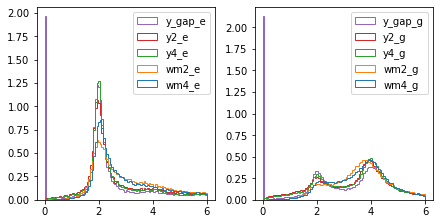

<IPython.core.display.Javascript object>

In [24]:
e_q = "backtracked_pdg==11 & backtracked_completeness>0.7 & trk_score_v <0.3 & shr_energy_y_v>100 & reco_fid_vol & shr_tkfit_dedx_nhits_y_v>0 & shr_tkfit_2cm_nhits_Y>0"
g_q = "backtracked_pdg==22 & backtracked_completeness>0.7 & trk_score_v <0.3 & shr_energy_y_v>100 & reco_fid_vol & shr_tkfit_dedx_nhits_y_v>0 & shr_tkfit_2cm_nhits_Y>0"

wm4_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_4cm_dedx_wm_v"]
wm4_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_4cm_dedx_wm_v"]
wm2_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_2cm_dedx_wm_v"]
wm2_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_2cm_dedx_wm_v"]
y4_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_dedx_y_v"]
y4_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_dedx_y_v"]
y2_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_2cm_dedx_Y"]
y2_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_2cm_dedx_Y"]
y_gap_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_gap10_dedx_y_v"]
y_gap_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_gap10_dedx_y_v"]

fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(6, 3))
ax[0].hist(
    [wm4_e, wm2_e, y4_e, y2_e, y_gap_e],
    label=["wm4_e", "wm2_e", "y4_e", "y2_e", "y_gap_e"],
    range=(0, 6),
    bins=100,
    histtype="step",
    density=1,
)
ax[0].legend()

ax[1].hist(
    [wm4_g, wm2_g, y4_g, y2_g, y_gap_g],
    label=["wm4_g", "wm2_g", "y4_g", "y2_g", "y_gap_g"],
    range=(0, 6),
    bins=100,
    histtype="step",
    density=1,
)
ax[1].legend()

In [25]:
%%time
# For MC samples
for k, v in all_samples.items():
    if k not in helper.data_samples:
        # Add distance between reco_sce and true vertex
        
        true_vtx = [v['mc'][f][v['mc']['n_pfps']>0] for f in ["true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z"]]
        reco_vtx = v["daughters"][[
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z"]].xs(0, level="daughter").values.T
        reco_vtx[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        v["daughters"]["true_vtx_distance"] = np.repeat(np.linalg.norm(true_vtx - reco_vtx, axis=0),v['mc']['n_pfps'][v['mc']['n_pfps']>0])
        
        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval('backtracked_overlay_purity>backtracked_purity')
        v["daughters"].loc[overlay_mask, 'backtracked_pdg'] = 0
        v["daughters"].loc[overlay_mask, 'backtracked_purity'] = v["daughters"].loc[overlay_mask, 'backtracked_overlay_purity']
        v["daughters"].loc[overlay_mask, 'backtracked_completeness'] = 0
        
        ## add truth weights:
        add_mc_fields = ['interaction',  'weightSplineTimesTune', 'leeweight', 'nu_e', 'nu_pdg', 'nueccinc', 'npion', 'npi0', 'nproton',"nelec", "nmuon", "nu_purity_from_pfp", "optical_filter"]
        if k != 'train':
            add_mc_fields.append('event_scale')
        for true_f in add_mc_fields:
            v['daughters'][true_f] = np.repeat(v['mc'][true_f],v['mc']['n_pfps'])
        
    else:
        v['daughters']["optical_filter"]=True

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


CPU times: user 4.61 s, sys: 960 ms, total: 5.57 s
Wall time: 5.57 s


<IPython.core.display.Javascript object>

In [26]:
%%time
# Add training labels and weights
e_cand = train["daughters"]['e_candidate']
e_good = train["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.8 & backtracked_completeness>0.8 & true_vtx_distance<5')
e_cand_bad = train["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11') 
other_bad = train["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13 | backtracked_pdg==0)')
other_neutral = train["daughters"].eval('~e_candidate & (backtracked_pdg==22 | abs(backtracked_pdg)==211)')
train["daughters"]['train_weight'] = train["daughters"].eval('weightSplineTimesTune+leeweight*@lee_focus') # weight low energy electrons a bit higher
train["daughters"]['train_weight'] = train["daughters"].eval('train_weight*(1+(shr_energy_y_v<600)*@lee_focus*e_candidate)') # weight low energy electrons a bit higher
train["daughters"].loc[e_good, "train_weight"] *= 2 # can be tuned
train["daughters"].loc[other_neutral, "train_weight"] = 1 # can be tuned

train["daughters"]['train_label'] = 1
train["daughters"].loc[e_cand_bad, "train_label"] = 0
train["daughters"].loc[other_bad, "train_label"] = 0
train["daughters"].loc[other_neutral, "train_label"] = 0

CPU times: user 1.03 s, sys: 379 ms, total: 1.41 s
Wall time: 1.41 s


<IPython.core.display.Javascript object>

In [27]:
gc.collect

<function gc.collect(generation=2)>

<IPython.core.display.Javascript object>

In [28]:
# What is the POT scaling before any cuts, after sliceID?
pass_nu = (
    all_samples["nu"]["daughters"]
    .xs(0, level="daughter")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .xs(0, level="daughter")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_off = (
    len(all_samples["off"]["daughters"].xs(0, level="daughter"))
    * all_samples["off"]["scaling"]
)
pass_on = (
    len(all_samples["on"]["daughters"].xs(0, level="daughter"))
    * all_samples["on"]["scaling"]
)
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

data/MC: 1.008


<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [29]:
%%time
# Passing rate pre-selection
for k, v in all_samples.items():
    v["daughters"]["preselect"] = v["daughters"].eval(query_preselect)
    v["daughters"]["preselect"] = v["daughters"]["preselect"].groupby(grouper, sort=False).transform(max)
    
    pass_rate = v["daughters"].eval("e_candidate & preselect").sum()/v['numentries']
    print("{} pass rate\t{:.2%}".format(k,pass_rate))
    
    if k=='train':
        for kind, name in {83: 'bnb', 81: 'lowe'}.items():
            sig_mask = (v["mc"]['sample']==kind) & v["mc"]['nueccinc']
            total_sig = v["mc"]["weightSplineTimesTune"][sig_mask].sum()
            pass_nuecc = v["daughters"].query("e_candidate & preselect & sample==@kind & nueccinc")['weightSplineTimesTune'].sum()/total_sig
            print("\t{}\t{:.2%}".format(name,pass_nuecc))
    if k=='nu':
        total_sig = v["mc"]["weightSplineTimesTune"][v["mc"]["nueccinc"]].sum()
        pass_nuecc = v["daughters"].query("e_candidate & preselect & nueccinc")["weightSplineTimesTune"].sum()/ total_sig
        print("\t{}\t{:.2%}".format("bnb", pass_nuecc))

on pass rate	0.23%
off pass rate	0.04%
nu pass rate	3.30%
	bnb	36.49%
dirt pass rate	0.03%
sideband pass rate	17.51%
train pass rate	4.28%
	bnb	37.39%
	lowe	17.37%
CPU times: user 2.45 s, sys: 70.7 ms, total: 2.52 s
Wall time: 2.52 s


<IPython.core.display.Javascript object>

In [30]:
# purity
pass_nuecc = (
    all_samples["nu"]["daughters"]
    .query("e_candidate & preselect & nueccinc")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_nu = (
    all_samples["nu"]["daughters"]
    .query("e_candidate & preselect")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .query("e_candidate & preselect")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_off = (
    all_samples["off"]["daughters"].eval("e_candidate & preselect").sum()
    * all_samples["off"]["scaling"]
)
pass_on = all_samples["on"]["daughters"].eval("e_candidate & preselect").sum()

print("nuecc-purity: {:.1%}".format(pass_nuecc / (pass_nu + pass_dirt + pass_off)))
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

nuecc-purity: 5.9%
data/MC: 0.916


<IPython.core.display.Javascript object>

In [31]:
%%time
for k, v in all_samples.items():
    e_pre_temp = v["daughters"].query("e_candidate & preselect")
    pre_temp = v["daughters"].query("preselect")
    dir_e_x = np.repeat(
        e_pre_temp.eval("trk_sce_end_x_v-trk_sce_start_x_v"), e_pre_temp["n_pfps"]
    ).values
    dir_e_y = np.repeat(
        e_pre_temp.eval("trk_sce_end_y_v-trk_sce_start_y_v"), e_pre_temp["n_pfps"]
    ).values
    dir_e_z = np.repeat(
        e_pre_temp.eval("trk_sce_end_z_v-trk_sce_start_z_v"), e_pre_temp["n_pfps"]
    ).values
    dir_d_x = pre_temp.eval("trk_sce_end_x_v-trk_sce_start_x_v").values
    dir_d_y = pre_temp.eval("trk_sce_end_y_v-trk_sce_start_y_v").values
    dir_d_z = pre_temp.eval("trk_sce_end_z_v-trk_sce_start_z_v").values

    e_vec = np.array([dir_e_x, dir_e_y, dir_e_z]).T
    d_vec = np.array([dir_d_x, dir_d_y, dir_d_z]).T
    cos_sim = (dir_e_x * dir_d_x + dir_e_y * dir_d_y + dir_e_z * dir_d_z) / (
        np.linalg.norm(d_vec, axis=1) * np.linalg.norm(e_vec, axis=1)
    )
    v["daughters"]["e_candidate_anglediff"] = 0
    v["daughters"].loc[v["daughters"]["preselect"], "e_candidate_anglediff"] = cos_sim

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 1.34 s, sys: 12.8 ms, total: 1.35 s
Wall time: 1.36 s


<IPython.core.display.Javascript object>

### Machine Learning Selection

In [32]:
col_train_electron = [
    "shr_dist_v",
    "shr_tkfit_4cm_dedx_wm_v",
    # "shr_tkfit_2cm_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_2cm_dedx_Y",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_moliere_avg_v",
    "shr_tkfit_hitratio_v",
    "shr_subclusters_v",
    "secondshower_Y_nhit",
    # "secondshower_Y_vtxdist",
    # "secondshower_Y_anglediff",
    # "ismerged",
    # "merge_bestdot",
    # "merge_bestdist",
    # "trkshrhitdist2",
]
col_train_other = [
    "trk_score_v",
    "trk_distance_v",
    # "trk_len_v",
    "trk_llr_pid_score_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    # "hits_per_tklen_v",
    # "shr_subclusters_v",
    "e_candidate_anglediff",
    "pfp_generation_v",
    "trk_muon_hypothesis_ratio_v",
    "trk_proton_hypothesis_ratio_v",
]

col_train_event = [
    "n_showers",
    "n_pfp_farvtx",
    # "hits_ratio",
    "contained_fraction",
    "score",
    "score_other_max",
    "score_other_min",
    "score_other_mean",
    # "all_start_contained",
    # "all_end_contained",
    # "mu_candidate_event"
    ## nueccinc
    ## train_weight -> use the train weight of the electron candidate
]

<IPython.core.display.Javascript object>

In [33]:
%%time
#remove completely crazy values
for k, v in all_samples.items():
    print(k)
    for col in col_train_electron+col_train_other+col_train_event:
        if col in v['daughters'].keys():
            v['daughters'][col] = np.clip(np.nan_to_num(v['daughters'][col], nan=-5, posinf=1000, neginf=-100), -100, 1000)

on
off
nu
dirt
sideband
train
CPU times: user 1.56 s, sys: 88.5 ms, total: 1.65 s
Wall time: 1.65 s


<IPython.core.display.Javascript object>

#### Electron training

In [34]:
train_q = "preselect & e_candidate"
X = train["daughters"].query(train_q)[col_train_electron]
Y = train["daughters"].query(train_q)[["train_label", "train_weight"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

<IPython.core.display.Javascript object>

In [35]:
# fit model no training data
depth = 5
if retrain:
    model_e = XGBClassifier(max_depth=depth)
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_e.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_e, model_dir + "model_e.pckl")
else:
    model_e = load(model_dir + "model_e.pckl")

<IPython.core.display.Javascript object>

In [36]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

              precision    recall  f1-score   support

    electron       0.87      0.77      0.81     18284
non_electron       0.68      0.81      0.74     11097

    accuracy                           0.78     29381
   macro avg       0.77      0.79      0.78     29381
weighted avg       0.80      0.78      0.78     29381

Test accuracy: 78.21%
Train accuracy: 79.55%

1. feature shr_dist_v (0.406786)
2. feature shr_moliere_avg_v (0.115516)
3. feature shr_tkfit_dedx_y_v (0.103206)
4. feature shr_tkfit_2cm_dedx_Y (0.088309)
5. feature shr_tkfit_4cm_dedx_wm_v (0.080856)
6. feature shr_tkfit_gap10_dedx_y_v (0.078377)
7. feature shr_subclusters_v (0.048331)
8. feature secondshower_Y_nhit (0.046542)
9. feature shr_tkfit_hitratio_v (0.032077)


<IPython.core.display.Javascript object>

In [37]:
if train_ana:
    param_range = range(1, 8)
    train_scores, test_scores = validation_curve(
        XGBClassifier(),
        X_train,
        y_train["train_label"],
        param_name="max_depth",
        param_range=param_range,
        scoring="accuracy",
        n_jobs=2,
    )

<IPython.core.display.Javascript object>

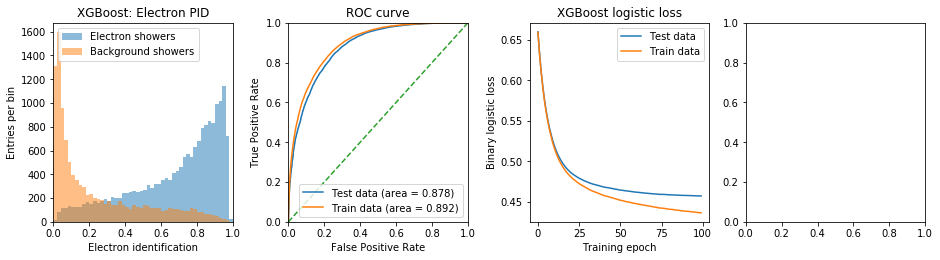

<IPython.core.display.Javascript object>

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_e.predict_proba(X_test).T[0]
y_pred_train = model_e.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["train_label"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"Electron showers",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Background showers",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Electron identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Electron PID")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_e.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")

if train_ana:
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax[3].set_title("Validation Curve")
    ax[3].set_xlabel(r"Tree depth")
    ax[3].set_ylabel("Accuracy")
    ax[3].set_ylim(0.84, 0.92)
    ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
    ax[3].fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
    )
    ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
    ax[3].fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
    )
    ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
    ax[3].legend(loc="upper left")
    ax[3].set_xticks(param_range)

fig.savefig(output_dir + "training/e_bdt_test.pdf")

#### Other daughters training

In [39]:
train_q = "preselect & ~e_candidate"
for k in ["train"]:
    X = train["daughters"].query(train_q)[col_train_other]
    Y = train["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )

<IPython.core.display.Javascript object>

In [40]:
# fit model on training data
depth = 6
if retrain:
    model_d = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_d.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_d, model_dir + "model_d.pckl")
else:
    model_d = load(model_dir + "model_d.pckl")

<IPython.core.display.Javascript object>

In [41]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                       precision    recall  f1-score   support

    proton, pion, ...       0.85      0.82      0.83     39162
muon, overlay, photon       0.75      0.79      0.77     26766

             accuracy                           0.81     65928
            macro avg       0.80      0.80      0.80     65928
         weighted avg       0.81      0.81      0.81     65928

Test accuracy: 80.65%
Train accuracy: 81.40%

1. feature trk_llr_pid_score_v (0.382910)
2. feature trk_distance_v (0.201966)
3. feature e_candidate_anglediff (0.081999)
4. feature trk_proton_hypothesis_ratio_v (0.071988)
5. feature trk_score_v (0.068836)
6. feature trk_muon_hypothesis_ratio_v (0.067883)
7. feature pfp_shr_daughters_v (0.050025)
8. feature pfp_generation_v (0.037862)
9. feature pfp_trk_daughters_v (0.036532)


<IPython.core.display.Javascript object>

In [42]:
if train_ana:
    param_range = range(1, 8)
    train_scores, test_scores = validation_curve(
        XGBClassifier(),
        X_train,
        y_train["train_label"],
        param_name="max_depth",
        param_range=param_range,
        scoring="accuracy",
        n_jobs=2,
        cv=2,
    )

<IPython.core.display.Javascript object>

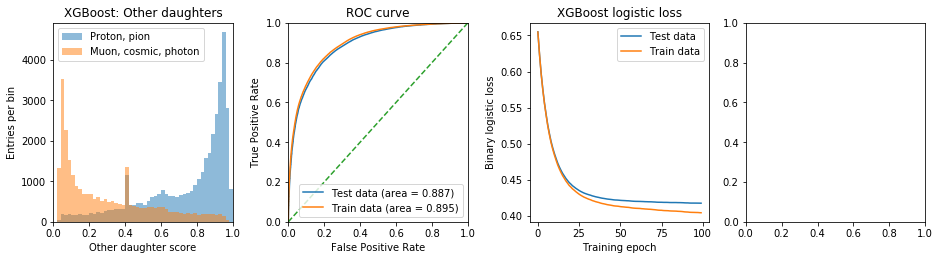

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_d.predict_proba(X_test).T[0]
y_pred_train = model_d.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["train_label"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"Proton, pion",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Muon, cosmic, photon",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Other daughter score")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Other daughters")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_d.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")

if train_ana:
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax[3].set_title("Validation Curve")
    ax[3].set_xlabel(r"Tree depth")
    ax[3].set_ylabel("Accuracy")
    ax[3].set_ylim(0.8, 0.85)
    ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
    ax[3].fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
    )
    ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
    ax[3].fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
    )
    ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
    ax[3].legend(loc="upper left")
    ax[3].set_xticks(param_range)

fig.savefig(output_dir + "training/daughter_bdt_test.pdf")

#### Apply models on the samples!

In [44]:
%%time
# add the columns for each daughter (all samples)
for k, v in all_samples.items():
    v["daughters"]["score"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score"] = model_e.predict_proba(
        v["daughters"][col_train_electron][mask_e_cand]
    ).T[1]
    mask_d = v["daughters"].eval("preselect & ~e_candidate")
    v["daughters"].loc[mask_d, "score"] = model_d.predict_proba(
        v["daughters"][col_train_other][mask_d]
    ).T[1]

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)


CPU times: user 5.1 s, sys: 504 ms, total: 5.61 s
Wall time: 5.61 s


<IPython.core.display.Javascript object>

#### Train on the events

In [45]:
%%time
# First we need to add some columns:
for k, v in all_samples.items():    
    print(k)
    
    mask_e = v["daughters"].eval("preselect & e_candidate & n_pfps>1")
    v["daughters"]["score_other_max"] = 1
    
    v["daughters"].loc[mask_e, "score_other_max"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .max()
        .values
    )
    v["daughters"]["score_other_mean"] = 1
    v["daughters"].loc[mask_e, "score_other_mean"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .mean()
        .values
    )
    v["daughters"]["score_other_min"] = 1
    v["daughters"].loc[mask_e, "score_other_min"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .min()
        .values
    )

on
off
nu
dirt
sideband
train
CPU times: user 2.94 s, sys: 996 ms, total: 3.94 s
Wall time: 3.94 s


<IPython.core.display.Javascript object>

In [46]:
train_q = "preselect & e_candidate"
train["daughters"]["nuecclabel"] = train["daughters"].eval(
    "nueccinc & backtracked_purity>0.5 & backtracked_completeness>0.5 & true_vtx_distance<10"
)
X = train["daughters"].query(train_q)[col_train_event]
Y = train["daughters"].query(train_q)[["nuecclabel", "train_weight"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

<IPython.core.display.Javascript object>

In [47]:
# fit model on training data
depth = 5
if retrain:
    model_event = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["nuecclabel"]), (X_test, y_test["nuecclabel"])]
    model_event.fit(
        X_train,
        y_train["nuecclabel"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_event, model_dir + "model_event.pckl")
else:
    model_event = load(model_dir + "model_event.pckl")

<IPython.core.display.Javascript object>

In [48]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nuecclabel"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nuecclabel"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nuecclabel"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                   precision    recall  f1-score   support

         nueccinc       0.88      0.88      0.88     19358
background events       0.76      0.78      0.77     10023

         accuracy                           0.84     29381
        macro avg       0.82      0.83      0.83     29381
     weighted avg       0.84      0.84      0.84     29381

Test accuracy: 84.26%
Train accuracy: 85.43%

1. feature score (0.623621)
2. feature score_other_mean (0.188310)
3. feature n_showers (0.061185)
4. feature score_other_min (0.043890)
5. feature score_other_max (0.040488)
6. feature n_pfp_farvtx (0.023708)
7. feature contained_fraction (0.018798)


<IPython.core.display.Javascript object>

In [49]:
if train_ana:
    param_range = range(1, 8)
    train_scores, test_scores = validation_curve(
        XGBClassifier(),
        X_train,
        y_train["nuecclabel"],
        param_name="max_depth",
        param_range=param_range,
        scoring="accuracy",
        n_jobs=2,
    )

<IPython.core.display.Javascript object>

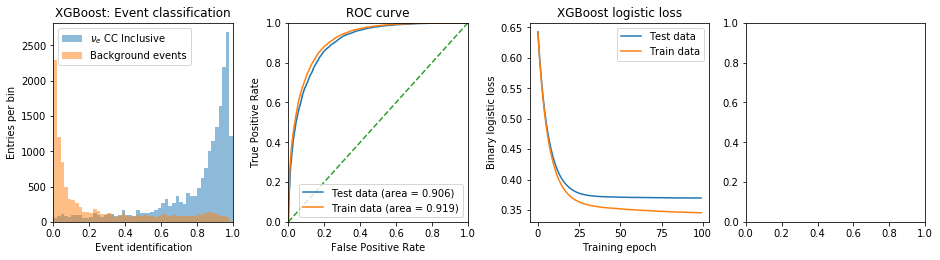

<IPython.core.display.Javascript object>

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_event.predict_proba(X_test).T[0]
y_pred_train = model_event.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["nuecclabel"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["nuecclabel"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["nuecclabel"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"$\nu_e$ CC Inclusive",
    density=False,
)
ax[0].hist(
    y_pred[y_test["nuecclabel"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Background events",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Event identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Event classification")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_event.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")

if train_ana:
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax[3].set_title("Validation Curve")
    ax[3].set_xlabel(r"Tree depth")
    ax[3].set_ylabel("Accuracy")
    ax[3].set_ylim(0.87, 0.92)
    ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
    ax[3].fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
    )
    ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
    ax[3].fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
    )
    ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
    ax[3].legend(loc="upper left")
    ax[3].set_xticks(param_range)

fig.savefig(output_dir + "training/event_bdt_test.pdf")

In [51]:
%time
# add the columns for each daughter (all samples)
for k, v in all_samples.items():
    print(k)
    v["daughters"]["score_event"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score_event"] = model_event.predict_proba(
        v["daughters"][col_train_event][mask_e_cand]
    ).T[1]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
on
off
nu


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


dirt
sideband
train


<IPython.core.display.Javascript object>

In [52]:
cut_val = 0.87
query_select = "e_candidate & preselect & score_event>@cut_val"

<IPython.core.display.Javascript object>

In [53]:
%%time
# Passing rate pre-selection
for k, v in all_samples.items():
    v['daughters']['select']=v['daughters'].eval(query_select)
    pass_rate = v["daughters"]['select'].sum()/v['numentries']
    print("{} pass rate\t{:.2%}".format(k,pass_rate))
    
    if k=='train':
        for kind, name in {83: 'bnb', 81: 'lowe'}.items():
            sig_mask = (v["mc"]['sample']==kind) & v["mc"]['nueccinc']
            total_sig = v["mc"]["weightSplineTimesTune"][sig_mask].sum()
            pass_nuecc = v["daughters"].query('select').query("sample==@kind & nueccinc")['weightSplineTimesTune'].sum()/total_sig
            print("\t{}\t{:.2%}".format(name,pass_nuecc))
    if k=='nu':
        total_sig = v["mc"]["weightSplineTimesTune"][v["mc"]["nueccinc"]].sum()
        pass_nuecc = v["daughters"].query('select').query("nueccinc")["weightSplineTimesTune"].sum()/ total_sig
        print("\t{}\t{:.2%}".format("bnb", pass_nuecc))

on pass rate	0.01%
off pass rate	0.00%
nu pass rate	0.86%
	bnb	18.39%
dirt pass rate	0.00%
sideband pass rate	0.60%
train pass rate	0.91%
	bnb	19.52%
	lowe	9.27%
CPU times: user 887 ms, sys: 376 ms, total: 1.26 s
Wall time: 1.26 s


<IPython.core.display.Javascript object>

In [54]:
# purity
pass_nuecc = (
    all_samples["nu"]["daughters"]
    .query("nueccinc & select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_nu = (
    all_samples["nu"]["daughters"]
    .query("select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .query("select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_off = (
    all_samples["off"]["daughters"]["select"].sum() * all_samples["off"]["scaling"]
)
pass_on = all_samples["on"]["daughters"]["select"].sum()

print("nuecc-purity: {:.1%}".format(pass_nuecc / (pass_nu + pass_dirt + pass_off)))
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

nuecc-purity: 52.3%
data/MC: 0.701


<IPython.core.display.Javascript object>

In [55]:
# Unblinded selected events:
np.savetxt(
    output_dir + "events_nuecc_selected.txt",
    all_samples["on"]["daughters"]
    .query("(e_candidate & select)")[["run", "sub", "evt"]]
    .sort_values(by=["run"]),
    fmt="%u",
)
print(len(all_samples["on"]["daughters"].query("(e_candidate & select)")))
all_samples["on"]["daughters"].query("(e_candidate & select)")[
    ["run", "sub", "evt", "score_event"]
].sort_values(by=["score_event"])

19


run  sub   evt  score_event
sample Run event  daughter                               
1      1   150697 0          5204   90  4508     0.870955
           153242 0          5374    4   227     0.872512
           121542 0          5360    0    45     0.880834
           106429 0          5532   46  2304     0.883899
           70390  0          5235    9   496     0.883988
           103099 0          5197    8   412     0.888417
           22624  0          5322    3   178     0.898488
       3   11206  0         14257   10   537     0.898488
           6311   0         15222  177  8886     0.907114
       1   24627  0          5729  121  6086     0.914777
       3   5807   0         14772   92  4642     0.921667
       1   33725  0          5364  114  5740     0.931852
           125484 0          5515  148  7402     0.959702
           69058  0          5557  151  7582     0.965310
           82766  0          5924    2   109     0.965441
           78004  0          5161    8   447     0.977458
           88438  0          5607   15   796     0.977656
           141172 0          5444    1    87     0.986712
           140429 0          5904   22  1128     0.988423

<IPython.core.display.Javascript object>

In [56]:
if "sideband" in all_samples:
    np.savetxt(
        output_dir + "events_nuecc_selected_sideband.txt",
        all_samples["sideband"]["daughters"]
        .query("(e_candidate & select)")[["run", "sub", "evt"]]
        .sort_values(by=["run"]),
        fmt="%u",
    )
    print(len(all_samples["sideband"]["daughters"].query("(e_candidate & select)")))

all_samples["sideband"]["daughters"].query(
    "(e_candidate & select)"
).index.get_level_values("Run").value_counts()

114


1    114
Name: Run, dtype: int64

<IPython.core.display.Javascript object>

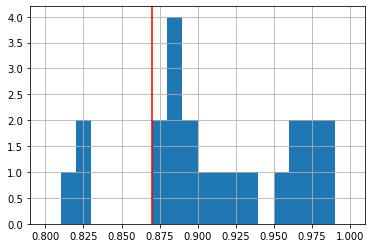

<IPython.core.display.Javascript object>

In [57]:
all_samples["on"]["daughters"].query("(e_candidate & preselect)")["score_event"].hist(
    range=(0.8, 1), bins=20
)
plt.axvline(x=cut_val, c="r")

In [58]:
Run3_good = [(15222, 177, 8886)]
Run1_good = [
    (5161, 8, 447),
    (5360, 0, 45),
    (5444, 1, 87),
    (5583, 13, 692),
    (5607, 15, 796),
    (5729, 121, 6086),
    (5197, 8, 412),
    (5924, 2, 109),
    (5904, 22, 1128),
    (5364, 114, 5740),
    (5326, 92, 4638),
]
q_all_good = "e_candidate & ("
for ev_good in Run1_good + Run3_good:
    q_all_good += "(run=={} & sub=={} & evt=={}) | ".format(*ev_good)

q_all_good = q_all_good[:-2] + ")"
print(q_all_good)
all_samples["on"]["daughters"].query(q_all_good)[
    [
        "run",
        "evt",
        "sub",
        "score",
        "score_event",
        "shr_energy_y_v",
        "shr_dist_v",
        "shr_tkfit_4cm_dedx_wm_v",
        "shr_tkfit_2cm_dedx_wm_v",
        "shr_tkfit_dedx_y_v",
        "shr_tkfit_2cm_dedx_Y",
        "shr_tkfit_gap10_dedx_y_v",
        "shr_moliere_avg_v",
        "shr_tkfit_hitratio_v",
        "shr_subclusters_v",
        "secondshower_Y_nhit",
        "contained_fraction",
    ]
]

e_candidate & ((run==5161 & sub==8 & evt==447) | (run==5360 & sub==0 & evt==45) | (run==5444 & sub==1 & evt==87) | (run==5583 & sub==13 & evt==692) | (run==5607 & sub==15 & evt==796) | (run==5729 & sub==121 & evt==6086) | (run==5197 & sub==8 & evt==412) | (run==5924 & sub==2 & evt==109) | (run==5904 & sub==22 & evt==1128) | (run==5364 & sub==114 & evt==5740) | (run==5326 & sub==92 & evt==4638) | (run==15222 & sub==177 & evt==8886) )


run   evt  sub     score  score_event  \
sample Run event  daughter                                            
1      1   24627  0          5729  6086  121  0.889059     0.914777   
           33725  0          5364  5740  114  0.768728     0.931852   
           78004  0          5161   447    8  0.949668     0.977458   
           82766  0          5924   109    2  0.965601     0.965441   
           88438  0          5607   796   15  0.971672     0.977656   
           103099 0          5197   412    8  0.815708     0.888417   
           121542 0          5360    45    0  0.963039     0.880834   
           127754 0          5326  4638   92  0.572170     0.792501   
           140429 0          5904  1128   22  0.976275     0.988423   
           141172 0          5444    87    1  0.983844     0.986712   
       3   6311   0         15222  8886  177  0.759441     0.907114   

                            shr_energy_y_v  shr_dist_v  \
sample Run event  daughter                               
1      1   24627  0             828.802307    0.252549   
           33725  0             564.865784    0.887717   
           78004  0            1026.401855    0.196993   
           82766  0            2792.385254    2.679116   
           88438  0            2004.926147    1.354943   
           103099 0            1473.672974    0.564971   
           121542 0             484.984344    0.789450   
           127754 0             106.817375    0.925742   
           140429 0             478.747345    0.593165   
           141172 0            1146.877075    1.346684   
       3   6311   0             303.459595    3.650781   

                            shr_tkfit_4cm_dedx_wm_v  shr_tkfit_2cm_dedx_wm_v  \
sample Run event  daughter                                                     
1      1   24627  0                        2.333313                 2.394586   
           33725  0                        7.646756                 6.690387   
           78004  0                        1.586149                 1.586677   
           82766  0                        3.334459                 4.077280   
           88438  0                        3.795423                 2.683938   
           103099 0                        4.431895                 3.401500   
           121542 0                        1.612558                 1.612517   
           127754 0                        2.149602                 2.473957   
           140429 0                        1.947023                 1.906314   
           141172 0                        5.480813                 6.163762   
       3   6311   0                        2.019120                 2.139230   

                            shr_tkfit_dedx_y_v  shr_tkfit_2cm_dedx_Y  \
sample Run event  daughter                                             
1      1   24627  0                   2.309928              2.705014   
           33725  0                   5.422145              7.249501   
           78004  0                   1.804561              1.770237   
           82766  0                   2.787252              2.787222   
           88438  0                   9.049864              1.598152   
           103099 0                   5.944706              4.198626   
           121542 0                   1.451203              1.451100   
           127754 0                   2.082618              2.050381   
           140429 0                   1.879645              1.834728   
           141172 0                   6.934304              7.209081   
       3   6311   0                   2.204308              1.921561   

                            shr_tkfit_gap10_dedx_y_v  shr_moliere_avg_v  \
sample Run event  daughter                                                
1      1   24627  0                         2.052225           6.119995   
           33725  0                         5.226874          11.169602   
           78004  0                         1.804561           5.482877  

<IPython.core.display.Javascript object>

In [59]:
if write_output_to_pickle:
    for sample in list(all_samples.keys()):
        if sample not in plot_samples:
            del all_samples[sample]
    pickle_out = open(input_dir + "after_training.pckl", "wb")
    pickle.dump(all_samples, pickle_out)
    pickle_out.close()
del train
gc.collect()

991

<IPython.core.display.Javascript object>

### Plots

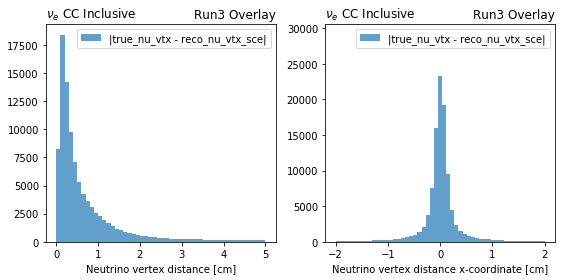

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    all_samples["nu"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

reco_nu_vtx_sce_x = (
    all_samples["nu"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")["reco_nu_vtx_sce_x"]
)
true_nu_vtx_x = all_samples["nu"]["mc"]["true_nu_vtx_x"][
    (all_samples["nu"]["mc"]["nueccinc"] > 0) & (all_samples["nu"]["mc"]["n_pfps"] > 0)
]
ax[1].hist(
    true_nu_vtx_x + x_sce_magic - reco_nu_vtx_sce_x,
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)

ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")